In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gc
import numpy as np
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from google.cloud import bigquery

### Download CSV for productivity Analysis

In [ ]:
BIGQUERY_PROJECT = "scisci-cssai-usf"  # replace this with your GCP project name
DISRUPTION_DATASET = "Disruption"

bq_client = bigquery.Client(project=BIGQUERY_PROJECT)

BQ_SQL = f""" 
SELECT Career_Age, 
       AVG(Paper_Count_In_Year) as AVG_Num_Of_Paper_In_Year,
       STDDEV(Paper_Count_In_Year) as STD_Paper_Count,
       COUNT(Paper_Count_In_Year) as COUNT_Paper_Count
FROM `{BIGQUERY_PROJECT}.{DISRUPTION_DATASET}.All_Yearly_Author_Profiles` 
WHERE Paper_Count_In_Year > 0
GROUP BY Career_Age
HAVING Career_Age < 80
ORDER BY Career_Age ASC
"""

job = bq_client.query(BQ_SQL)
temp_df = job.to_dataframe()
temp_df['STD_ERR'] = temp_df['STD_Paper_Count'] / np.sqrt(temp_df['COUNT_Paper_Count'])
temp_df.to_csv("data/average_num_of_papers_by_career_age.csv", index=False)


# productivity pattern of First Year Authors -- Evaluation of the work of their debut year 
BQ_SQL = f"""
SELECT 
       Paper_Count_In_Prev_Years,
       AVG(Avg_Disruption) as Avg_Avg_Disruption, 
       STDDEV(Avg_Disruption) as STD_Avg_Disruption,
       COUNT(Avg_Disruption) as COUNT_Avg_Disruption
FROM `{BIGQUERY_PROJECT}.{DISRUPTION_DATASET}.All_Yearly_Author_Profiles`
WHERE Career_Age = 1 
GROUP BY Paper_Count_In_Prev_Years
ORDER BY Paper_Count_In_Prev_Years ASC
"""

job = bq_client.query(BQ_SQL)
temp_df = job.to_dataframe()
temp_df['STD_ERR'] = temp_df['STD_Avg_Disruption'] / np.sqrt(temp_df['COUNT_Avg_Disruption'])
temp_df.to_csv("data/beginner_authors_productivity_pattern.csv", index=False)

In [3]:
def setup_plotting_style():
    plt.figure(figsize=(8, 6), dpi=300)

    sns.set_style("white")

    plt.rcParams["font.size"] = 12
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.titlesize"] = 16
    plt.rcParams["xtick.labelsize"] = 12
    plt.rcParams["ytick.labelsize"] = 12
    plt.rcParams["legend.fontsize"] = 12
    plt.rcParams["figure.titlesize"] = 18

    plt.rcParams["axes.linewidth"] = 1.5
    plt.rcParams["grid.linewidth"] = 0.8
    plt.rcParams["lines.linewidth"] = 2.0

    sns.set_palette("colorblind")

    # Save format settings
    plt.rcParams["savefig.format"] = "pdf"
    plt.rcParams["savefig.bbox"] = "tight"
    plt.rcParams["savefig.pad_inches"] = 0.1

### Career Age vs Productivity

In [4]:
df = pd.read_csv("data/average_num_of_papers_by_career_age.csv")

def get_career_stage(career_age):
    if career_age == 0:
        return "First-Time"
    elif career_age <= 10:
        return "Early-Career"
    else:
        return "Senior"


df.loc[:, "Career Stage"] = df["Career_Age"].apply(get_career_stage)

df.groupby("Career Stage")["AVG_Num_Of_Paper_In_Year"].mean()

Career Stage
Early-Career    2.228466
First-Time      1.197507
Senior          3.900868
Name: AVG_Num_Of_Paper_In_Year, dtype: float64

In [5]:
subset = df[(df["Career_Age"] >= 0) & (df["Career_Age"] <= 50)].copy()
subset["Increase"] = subset["AVG_Num_Of_Paper_In_Year"].diff().fillna(0)
subset[["Career_Age", "AVG_Num_Of_Paper_In_Year", "Increase"]]

,Career_Age,AVG_Num_Of_Paper_In_Year,Increase
0,0,1.197507,0.000000
1,1,1.741094,0.543587
2,2,1.874071,0.132976
3,3,1.995410,0.121339
4,4,2.094370,0.098960
5,5,2.193099,0.098730
6,6,2.286179,0.093080
7,7,2.389777,0.103598
8,8,2.475552,0.085775
9,9,2.572743,0.097190


<Figure size 2400x1800 with 0 Axes>

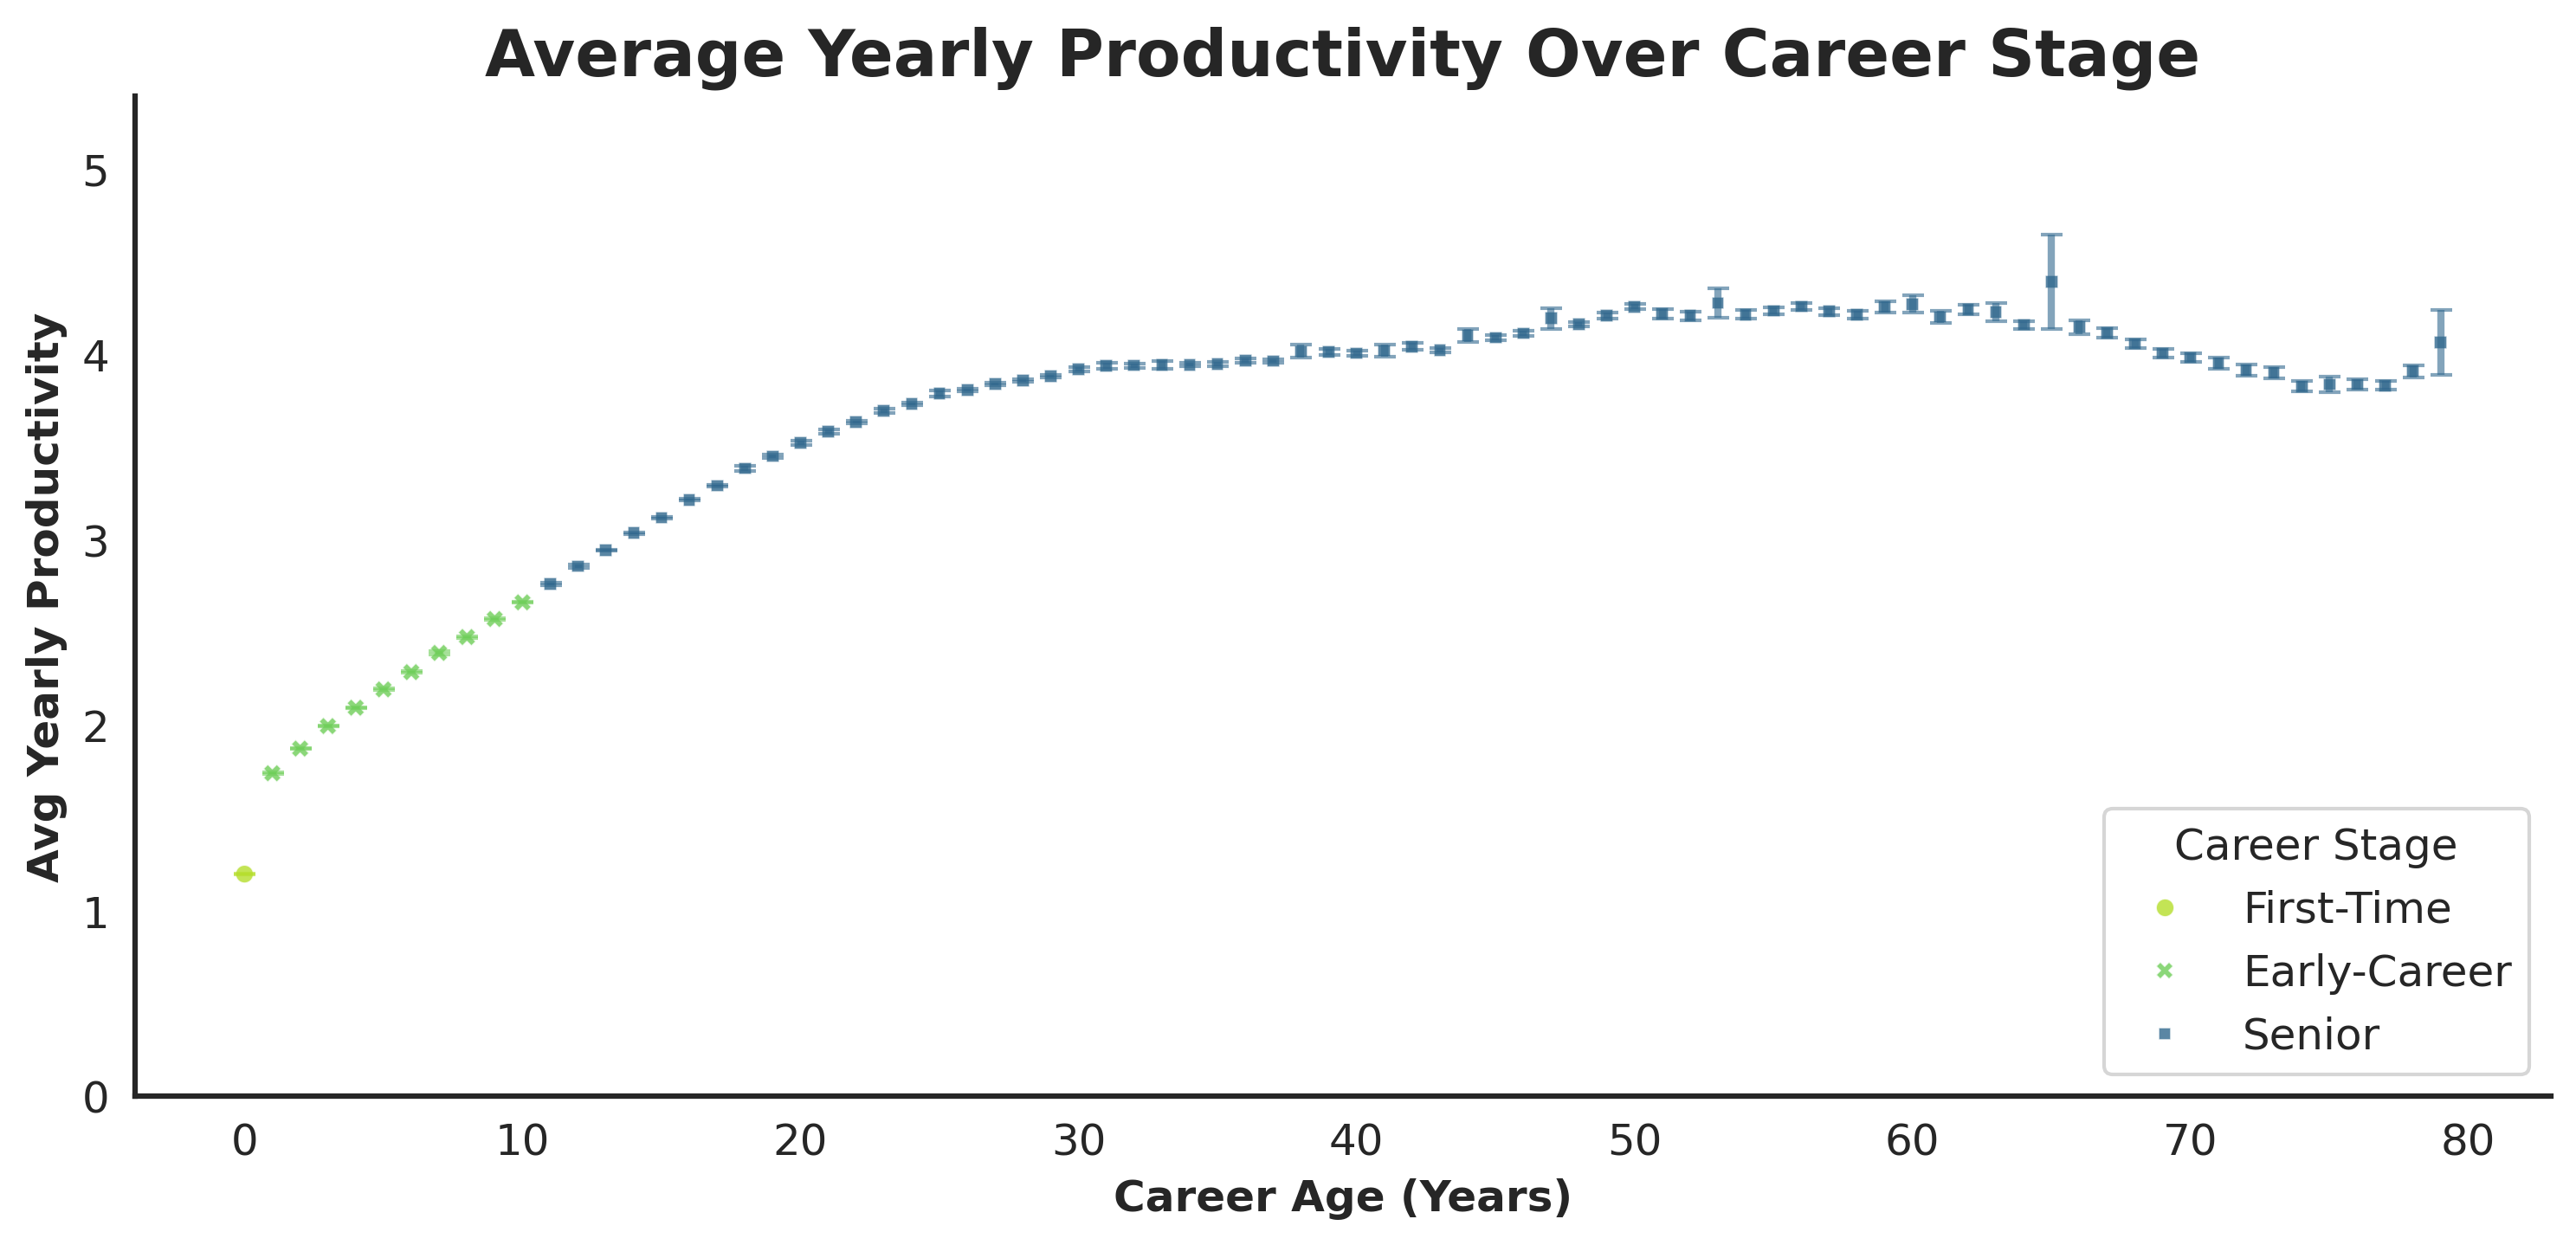

In [15]:
def plot_career_age_vs_yearly_paper(df, show_avg=True):
    setup_plotting_style()

    # Create the color palette as specified
    full_palette = sns.color_palette("viridis_r", 8)
    color_indices = [0, 1, 3, 5]
    selected_colors = [full_palette[i] for i in color_indices]

    # Create a dictionary to map career stages to colors
    career_stages = ["First-Time", "Early-Career", "Mid-Career", "Senior"]
    color_dict = dict(zip(career_stages, selected_colors))

    plt.figure(figsize=(12, 5), dpi=300)

    # Plot the scatter points with error bars
    sns.scatterplot(
        data=df,
        x="Career_Age",
        y="AVG_Num_Of_Paper_In_Year",
        hue="Career Stage",
        style="Career Stage",
        palette=color_dict,
        s=25,
        alpha=0.8,
    )
    
    # Add error bars
    for stage in career_stages:
        stage_data = df[df["Career Stage"] == stage]
        plt.errorbar(
            stage_data["Career_Age"],
            stage_data["AVG_Num_Of_Paper_In_Year"],
            yerr=stage_data["STD_ERR"],
            fmt='none',
            ecolor=color_dict[stage],
            alpha=0.6,
            capsize=3,
            capthick=1
        )

    # Calculate and plot the average for each career stage with y limits
    if show_avg:
        for stage in career_stages:
            stage_data = df[df["Career Stage"] == stage]
            avg_papers = stage_data["AVG_Num_Of_Paper_In_Year"].mean()

            # Define x-range for each career stage
            if stage == "First-Time":
                x_min, x_max = 0, 0
                x_pos = 0
            elif stage == "Early-Career":
                x_min, x_max = 1, 4
                x_pos = 2.5
            elif stage == "Mid-Career":
                x_min, x_max = 5, 9
                x_pos = 7.5
            else:  # Senior
                x_min, x_max = 10, df["Career_Age"].max()
                x_pos = 15

            # Add the average value as text
            # plt.text(x_pos - 0.2, avg_papers - 0.2, f"Avg: {avg_papers:.2f}",
            #          color=color_dict[stage], fontweight='bold', ha='center')

            # Draw a horizontal line for the average ONLY within the career stage range
            plt.hlines(
                y=avg_papers,
                xmin=x_min,
                xmax=x_max,
                colors=color_dict[stage],
                linestyles="--",
                alpha=0.7,
                linewidth=2,
            )

    plt.title(
        f"Average Yearly Productivity Over Career Stage", fontweight="bold", fontsize=18
    )
    plt.xlabel("Career Age (Years)", fontweight="bold", fontsize=12)
    plt.ylabel("Avg Yearly Productivity", fontweight="bold", fontsize=12)
    plt.ylim(0, df["AVG_Num_Of_Paper_In_Year"].max() + 1)
    plt.legend(title="Career Stage", loc="lower right")
    sns.despine()

plot_career_age_vs_yearly_paper(df, False)
plt.savefig("Figures/Sup_2_Career_Age_Vs_Avg_Paper.pdf", bbox_inches="tight")

In [7]:
def test_first_time_difference():
    # Get data for each group
    first_time_data = df[df["Career Stage"] == "First-Time"]["AVG_Num_Of_Paper_In_Year"]
    early_career_data = df[df["Career Stage"] == "Early-Career"][
        "AVG_Num_Of_Paper_In_Year"
    ]
    mid_career_data = df[df["Career Stage"] == "Mid-Career"]["AVG_Num_Of_Paper_In_Year"]
    senior_data = df[df["Career Stage"] == "Senior"]["AVG_Num_Of_Paper_In_Year"]

    # Check if first_time_data has more than one value (needed for statistical tests)
    if len(first_time_data) <= 1:
        print("First-Time data has only one value, which limits statistical testing.")
        print(f"First-Time mean: {first_time_data.mean()}")

    # Descriptive statistics
    print("\nDescriptive statistics by career stage:")
    stats_df = df.groupby("Career Stage")["AVG_Num_Of_Paper_In_Year"].agg(
        ["count", "mean", "std", "min", "max"]
    )
    print(stats_df)

    # Since Senior data is not normal, we'll use non-parametric tests for all comparisons
    print("\nComparing First-Time with other stages (Mann-Whitney U test):")

    # Function to run Mann-Whitney U test (non-parametric)
    def compare_groups_nonparametric(group1, group2, name1, name2):
        if len(group1) <= 1 or len(group2) <= 1:
            print(f"{name1} vs {name2}: Cannot perform test - insufficient data")
            return

        try:
            stat, p = mannwhitneyu(group1, group2)
            print(
                f"{name1} vs {name2}: p-value = {p:.4f}, {'Significant' if p < 0.05 else 'Not significant'}"
            )

            # Calculate effect size (r = Z / sqrt(N))
            n1, n2 = len(group1), len(group2)
            N = n1 + n2

            # Calculate Z-score from p-value (approximation)
            from scipy.stats import norm

            z = norm.ppf(1 - p / 2)  # Two-tailed p-value to z-score
            r = z / np.sqrt(N)

            print(
                f"Effect size (r): {abs(r):.2f}, "
                + f"({'Small' if abs(r) < 0.3 else 'Medium' if abs(r) < 0.5 else 'Large'} effect)"
            )

            # Also calculate the percentage difference
            mean1, mean2 = group1.mean(), group2.mean()
            percent_diff = ((mean2 - mean1) / mean1) * 100
            print(f"Percentage difference: {percent_diff:.1f}%")

        except Exception as e:
            print(f"{name1} vs {name2}: Error in test - {e}")

    # Compare First-Time with each other group using non-parametric tests
    if len(first_time_data) > 1:
        compare_groups_nonparametric(
            first_time_data, early_career_data, "First-Time", "Early-Career"
        )
        compare_groups_nonparametric(
            first_time_data, mid_career_data, "First-Time", "Mid-Career"
        )
        compare_groups_nonparametric(
            first_time_data, senior_data, "First-Time", "Senior"
        )

    # For cases where First-Time has only one data point, we can still show the magnitude of differences
    else:
        ft_mean = first_time_data.mean()
        print(
            "\nSince First-Time has only one data point, showing percentage differences:"
        )
        print(
            f"First-Time vs Early-Career: {((early_career_data.mean() - ft_mean) / ft_mean * 100):.1f}% difference"
        )
        print(
            f"First-Time vs Mid-Career: {((mid_career_data.mean() - ft_mean) / ft_mean * 100):.1f}% difference"
        )
        print(
            f"First-Time vs Senior: {((senior_data.mean() - ft_mean) / ft_mean * 100):.1f}% difference"
        )

    # Kruskal-Wallis test (non-parametric alternative to ANOVA)
    print("\nKruskal-Wallis test across all career stages:")
    try:
        all_data = [first_time_data, early_career_data, mid_career_data, senior_data]
        # Filter out any empty groups
        all_data = [group for group in all_data if len(group) > 0]
        if len(all_data) >= 2:  # Need at least 2 groups for the test
            stat, p = stats.kruskal(*all_data)
            print(
                f"p-value = {p:.4f}, {'Significant' if p < 0.05 else 'Not significant'}"
            )
        else:
            print("Cannot perform Kruskal-Wallis test - insufficient data")
    except Exception as e:
        print(f"Error in Kruskal-Wallis test: {e}")


# Run the analysis
test_first_time_difference()

First-Time data has only one value, which limits statistical testing.
First-Time mean: 1.1975073652823476

Descriptive statistics by career stage:
              count      mean       std       min       max
Career Stage                                               
Early-Career     10  2.228466  0.304389  1.741094  2.662364
First-Time        1  1.197507       NaN  1.197507  1.197507
Senior           69  3.900868  0.362585  2.761551  4.390732

Comparing First-Time with other stages (Mann-Whitney U test):

Since First-Time has only one data point, showing percentage differences:
First-Time vs Early-Career: 86.1% difference
First-Time vs Mid-Career: nan% difference
First-Time vs Senior: 225.7% difference

Kruskal-Wallis test across all career stages:
p-value = 0.0000, Significant


### Beginner Author's Productivity vs Disruption

<Figure size 2400x1800 with 0 Axes>

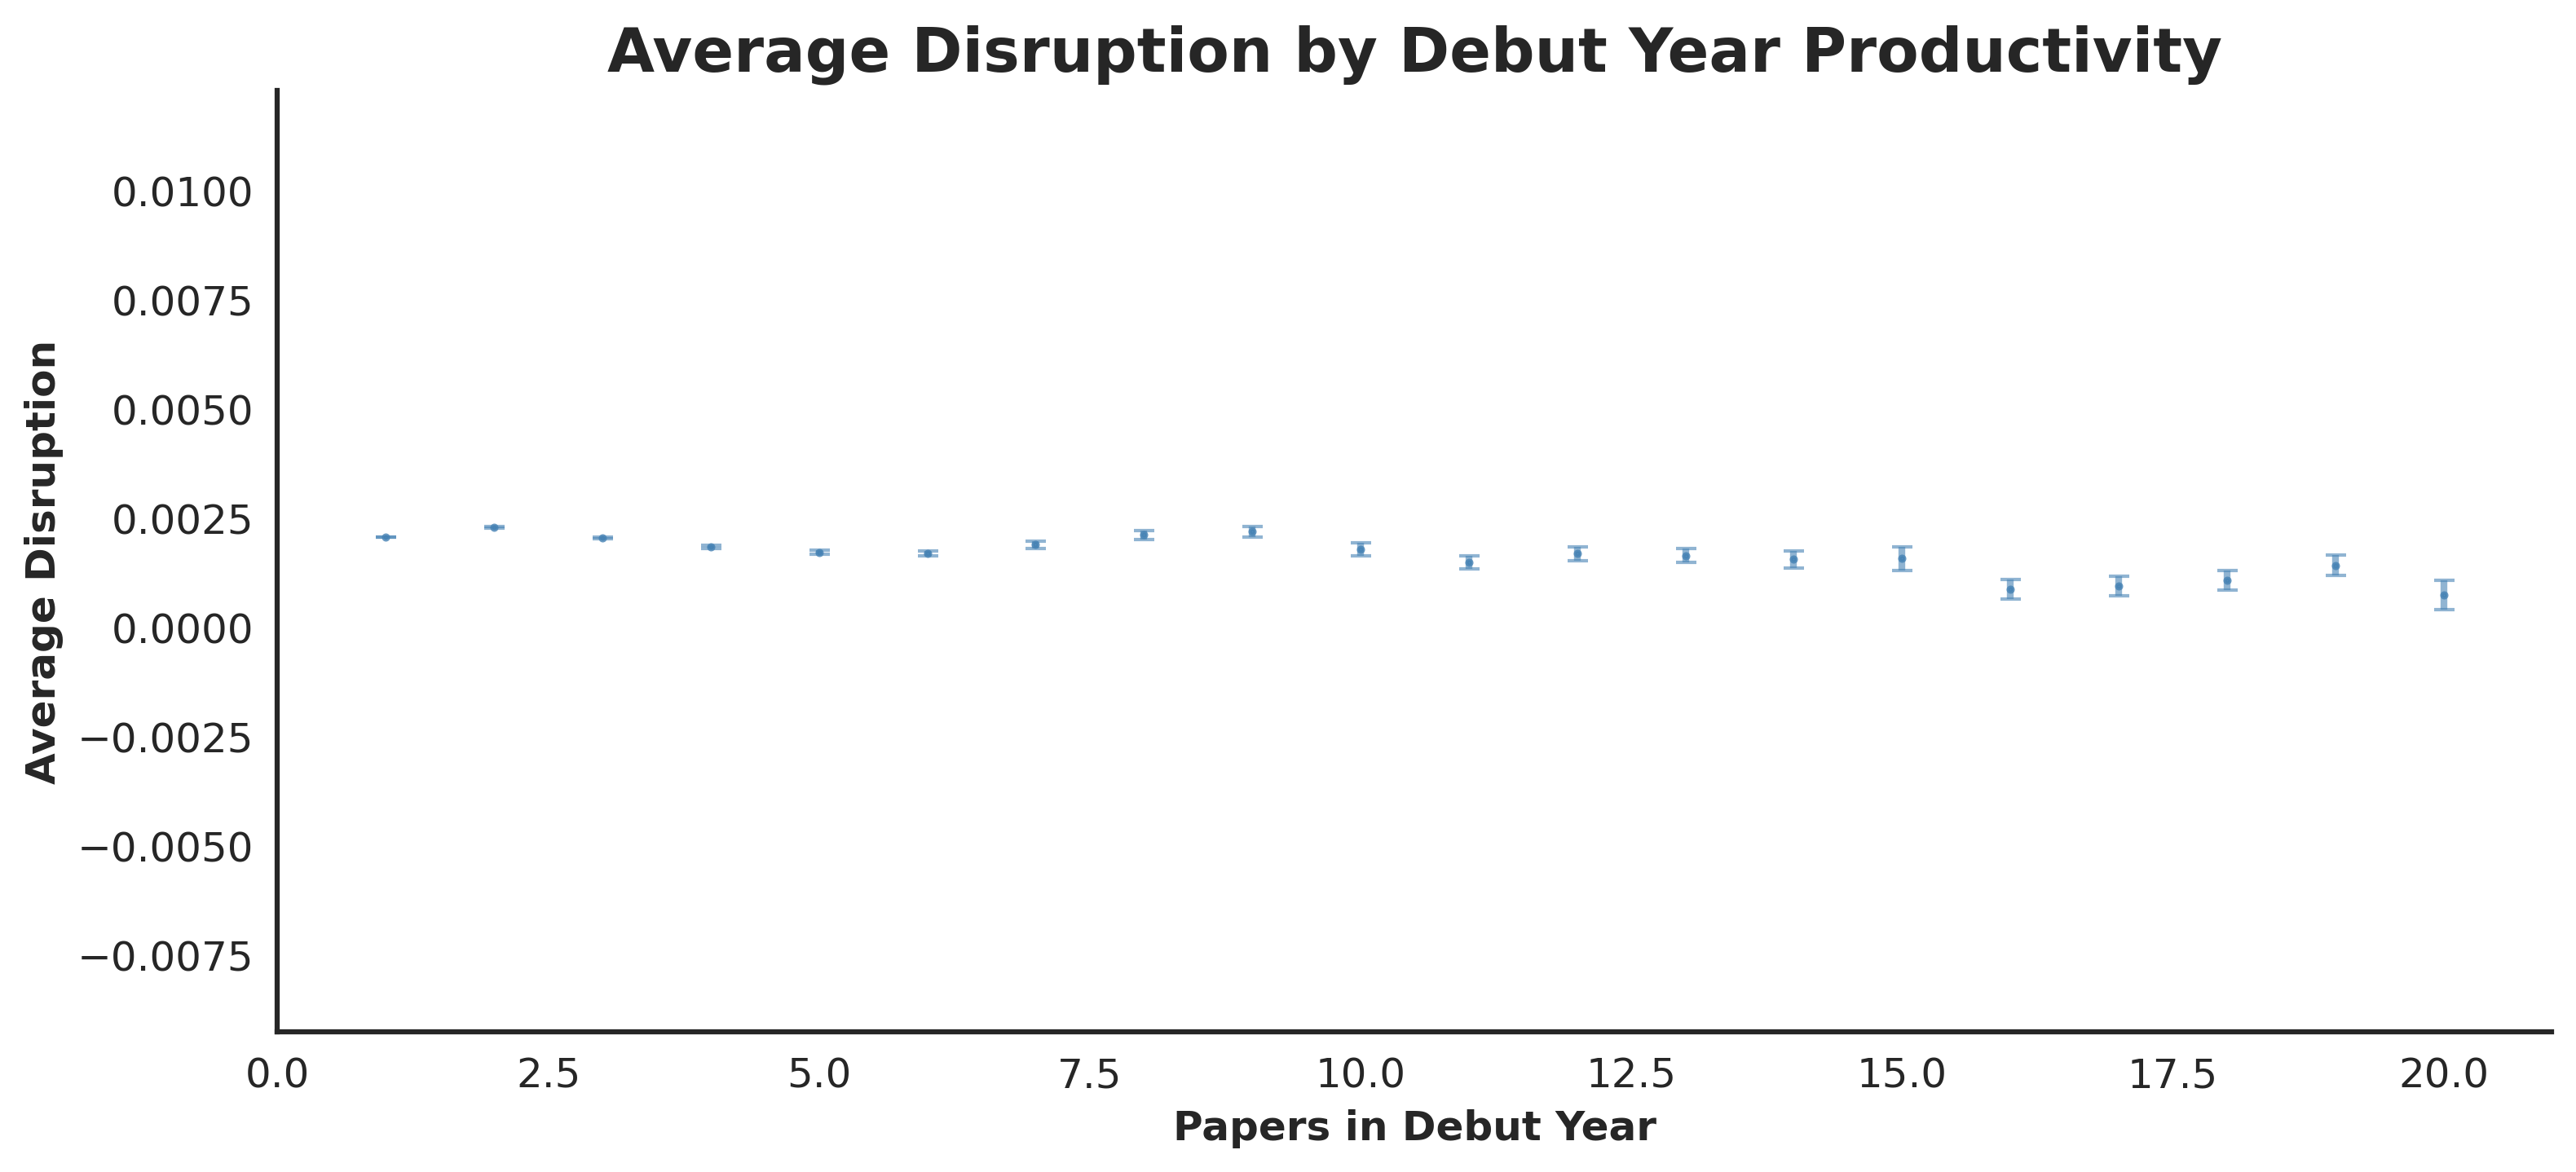

In [13]:
df_debut = pd.read_csv("data/beginner_authors_productivity_pattern.csv")
df_debut = df_debut[df_debut["Paper_Count_In_Prev_Years"] <= 20]

def plot_debut_papers_vs_disruption(df):
    setup_plotting_style()

    plt.figure(figsize=(12, 5), dpi=300)

    # Plot scatter points for each paper count from 1 to 20
    plt.scatter(
        df["Paper_Count_In_Prev_Years"],
        df["Avg_Avg_Disruption"],
        s=2,
        alpha=0.8,
        color='steelblue'
    )
    
    # Add error bars for each point
    plt.errorbar(
        df["Paper_Count_In_Prev_Years"],
        df["Avg_Avg_Disruption"],
        yerr=df["STD_ERR"],
        fmt='none',
        ecolor='steelblue',
        alpha=0.6,
        capsize=3,
        capthick=1
    )

    plt.title(
        f"Average Disruption by Debut Year Productivity", fontweight="bold", fontsize=18
    )
    plt.xlabel("Papers in Debut Year", fontweight="bold", fontsize=12)
    plt.ylabel("Average Disruption", fontweight="bold", fontsize=12)
    plt.xlim(0, 21)
    plt.ylim(df["Avg_Avg_Disruption"].min() - 0.01, df["Avg_Avg_Disruption"].max() + 0.01)
    sns.despine()

plot_debut_papers_vs_disruption(df_debut)
plt.savefig("Figures/Debut_Year_Papers_Vs_Disruption.pdf", bbox_inches="tight")